# Market Neutral Strategy with Stock Style Matching

- Hyeonjun Kim, Estimation Company
- Original Notebook Documented on Aug 11, 2023
- Contact: hyeonjunacademic@gmail.com

This strategy aims to identify pairs of stocks with similar risk styles. To achieve this, we utilized principal component analysis (PCA) to extract common risk factors and calculated pairwise cosine similarity between these risk factor loadings (exposures).

Consider the following asset pricing model for stock $i$:

$$
R^{(i)}(t) = \alpha^{(i)} + \beta^{(i)}_1 F_1(t) + \beta^{(i)}_2 F_2(t) + \cdots + \beta^{(i)}_n F_n(t) + \epsilon
$$

Here, $F_k$ represents the $k$th eigenportfolio obtained through Principal Component Analysis. We obtain a vector of factor loadings for stock $i$ denoted as $B^{(i)} = [\beta^{(i)}_1 \ \beta^{(i)}_2 \ \cdots \ \beta^{(i)}_n]$, which we can consider as risk characteristics.

If these factors fully price the stock returns, we have $\alpha = 0$. I propose two hypotheses. First, if the factors completely explain variations in stock returns, the residual follows a mean-reverting process denoted as $X_t$. The second hypothesis is that similar risk characteristics, excluding the effect of leverage, lead to similar return patterns.

If these hypotheses hold true, a high similarity metric of risk factor loadings between two stocks will indicate that the cumulative return spread of a portfolio holding long positions in stock A and short positions in stock B will be mean-reverting.

This can be demonstrated by defining the weights of the stock A long - stock B short portfolio as the negation of the historical cumulative spread transformed using the sigmoid function. This transformation is necessary because the strategy's weight should lie within the range of -1 to 1, while also adjusting as the cumulative spread increases or decreases.

The resulting strategy implies that the weight of the stock A long - stock B short portfolio at time $t$ increases above 0 as the cumulative spread of the portfolio returns from time 0 to $t-1$ becomes more negative. Conversely, the weight decreases below 0 as the cumulative spread becomes more positive.

The data used consists of daily Korean stock returns, including dividends. While the specific data is not provided, you can substitute any dataset containing daily stock returns, including delisted firms.


In [208]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import seaborn as sns

In [239]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Daily return of Korean stock including dividend
data0 = pd.read_csv("현금배당포함수익률.csv", index_col=0, parse_dates=True, thousands=",") / 100

#changing it to monthly data

data = np.expm1(np.log1p(data0).resample("m").sum()) * np.where(np.log1p(data0).resample("m").last().isna(), np.nan, 1)

data

,A005930,A373220,A207940,A000660,A051910,A006400,A005380,A035420,A000270,A068270,...,A900080,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950180
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.055332,NaN,NaN,NaN,NaN,-0.110822,-0.006668,NaN,-0.035038,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-28,0.016348,NaN,NaN,NaN,NaN,0.032702,-0.027421,NaN,0.012074,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-31,0.050416,NaN,NaN,NaN,NaN,0.066087,0.010833,NaN,-0.012069,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-30,-0.196790,NaN,NaN,NaN,NaN,-0.190057,-0.248944,NaN,-0.258106,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-31,0.111585,NaN,NaN,NaN,NaN,0.105436,0.144804,NaN,0.173746,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.027779,0.095937,-0.034858,-0.027508,0.048224,0.050958,-0.000130,-0.073442,-0.004958,-0.002713,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,-0.104433,-0.077776,-0.033652,-0.123955,-0.151795,-0.087040,-0.099499,-0.190099,-0.110166,-0.073853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,0.118415,0.238075,0.086801,-0.004769,0.167579,0.349853,-0.067942,-0.123992,-0.078007,0.094075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
#transaction cost of one unit long short position change transaction
transact = 0.01

In [229]:

#strategy 

def testLongshort(x1, x2, const, train, test):
    ret0 = (test[x1] - test[x2])
    
    ret = ((ret0).cumsum())
    
    ret1 = (train[x1] - train[x2])
    ret1 = ((ret1).cumsum())


    signal = (-ret).shift(1)

    signal = 1 / (1 + np.exp(-signal))
    signal = (signal - 0.5) * 2
    switchs = signal.diff().abs()

    return ret0 * signal.values - (switchs.values * transact)

In [230]:
#mean reversion test
#citing method of <Statistical Arbitrage in the U.S. Equities Market>

def testLongshort1(x1, x2, const, train,test):
    ret = (test[x1]- test[x2]).dropna()
    ret = ((ret).cumsum())
    
    df = pd.DataFrame({"ret":ret, "ret1l":ret.shift(1)}).dropna()
    
    if df.shape[0] < 10:
        
        return np.nan
    
    mo = sm.OLS(df["ret"], sm.add_constant(df["ret1l"])).fit()
    
    params = mo.params
    
    a = params["const"]
    b = params["ret1l"]
    var = np.var(mo.resid)
    
    kappa = - np.log(b) * 12
    
    sigma = np.sqrt(var * 2 * kappa / (1 -(b ** 2)))
    
    # mean reverting characteristics
    return kappa 

In [243]:
port = pd.Series(np.zeros((1)))

result = pd.DataFrame(np.zeros((0, 0)))

#test from 2010 to 2022
for year in tqdm(range(2009, 2021)):
    
    #train test split
    train = data[f"{year-15}":f"{year}"].dropna(axis=1)
    train0 = (train - train.shift(1).rolling(60).mean()) / train.shift(1).rolling(60).std()
    train0 = train0.dropna()
    dropCol = pd.Series(np.where((train0.abs() ==np.inf).any(axis=0).values, np.nan, train0.columns)).dropna().values
    train0 = train0[list(dropCol)]
    train= train[list(dropCol)]
    test = data0[f"{year+1}-01":f"{year+1}-12"]
    #factor extraction
    model = PCA(n_components=50)
    model.fit(train0)
    #factors = (train.loc[train.index, :] @ model.components_.T) / np.sum(model.components_, axis=1).reshape(1, -1)
    const = None
    #calculating loadings for each factors
    #riskLoading = {}

    #for col in (train.columns):

     #   factors["y"] = train[col]

      #  factors = factors.dropna()


       # risk = sm.OLS(factors["y"], sm.add_constant(factors.drop("y", axis=1))).fit().params

        #riskLoading[col] = risk
    riskLoading = pd.DataFrame(model.components_.T, index=train.columns)
    #seperate constant(alpha) from factor model
    #riskLoading = pd.DataFrame(riskLoading).T
    #const = riskLoading["const"]
    #as the similarity measure is cosine similarity, the loadings' average is set to zero.
    riskLoading = (riskLoading - riskLoading.mean())
    #riskLoading = riskLoading.drop("const", axis=1)
    
    #calculating cosine similarity of factor loading
    cosi = pd.DataFrame(cosine_similarity(riskLoading), index=riskLoading.index, columns=riskLoading.index)
    
    for n in range(cosi.shape[0]):

        cosi.iloc[n ,n] = np.nan
    

    cosi = pd.DataFrame(np.tril(cosi, k=0), index=cosi.index, columns=cosi.index)
    
    #find the most similar pair of stocks in risk chracteristics
    X = cosi.reset_index().melt(id_vars="index", value_vars=cosi.columns).sort_values(by="value").dropna().iloc[::-1, :]
    X = pd.DataFrame(X)
    x = list(X.iloc[:1000]["index"])
    y = list(X.iloc[:1000]["variable"])
    z = list(X.iloc[:1000]["value"])

    
    test1 = data[f"{year+1}-01":f"{year+1}-12"]

    aList = []

    for n in range(len(x)):

        aList.append([testLongshort1(x[n], y[n], const, train, test1), z[n], year])

    result = pd.concat([result, pd.DataFrame(aList)], axis=0)



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.62s/it]


In [244]:
#result processing 
result.columns = ["estimation", "similarity", "year"]
result["estimation"] = result["estimation"].where(result["estimation"].abs() != np.inf, np.nan)
result = result.dropna()


#### Pooled Regression Analysis

Higher the risk loading similarity, higher the $\kappa$. Statistical Significance is observed.

<Axes: xlabel='similarity', ylabel='estimation'>

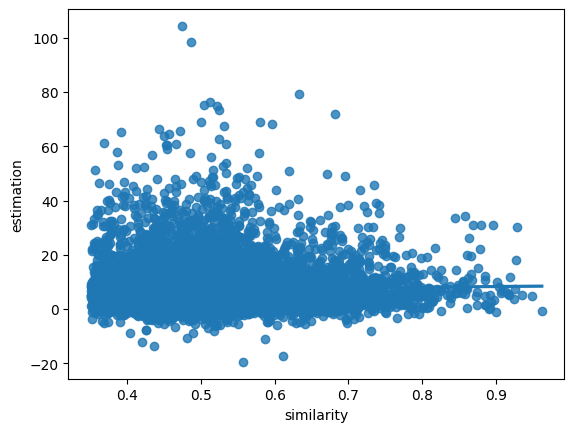

In [245]:
sns.regplot(data=result, x="similarity", y="estimation")

In [246]:
(sm.OLS(result["similarity"], sm.add_constant(result["estimation"])).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.592
Date:                Sat, 19 Aug 2023   Prob (F-statistic):             0.0103
Time:                        13:25:50   Log-Likelihood:                 10729.
No. Observations:               11170   AIC:                        -2.145e+04
Df Residuals:                   11168   BIC:                        -2.144e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5050      0.001    421.983      0.000       0.503       0.507
estimation     0.0003      0.000      2.567      0.010    6.65e-05       0.000
==============================================================================
Omnibus:                     1602.232   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2676.453
Skew:                           0.966   Prob(JB):                         0.00
Kurtosis:                       4.420   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Yearly Regression

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.332
Date:                Sat, 19 Aug 2023   Prob (F-statistic):             0.0211
Time:                        13:23:00   Log-Likelihood:                 1140.8
No. Observations:                1000   AIC:                            -2278.
Df Residuals:                     998   BIC:                            -2268.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4266      0.004    120.066      0.0

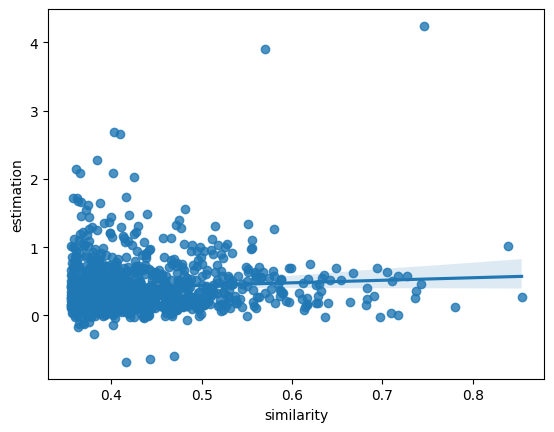

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.555
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.110
Time:                        13:23:00   Log-Likelihood:                 1124.9
No. Observations:                1000   AIC:                            -2246.
Df Residuals:                     998   BIC:                            -2236.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4420      0.003    133.235      0.0

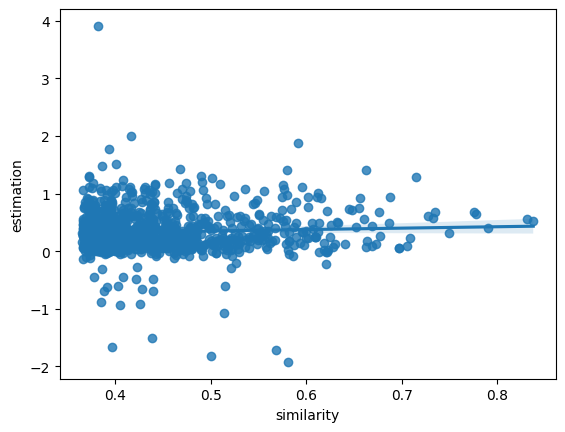

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8547
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.355
Time:                        13:23:00   Log-Likelihood:                 1089.0
No. Observations:                 996   AIC:                            -2174.
Df Residuals:                     994   BIC:                            -2164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4911      0.003    152.515      0.0

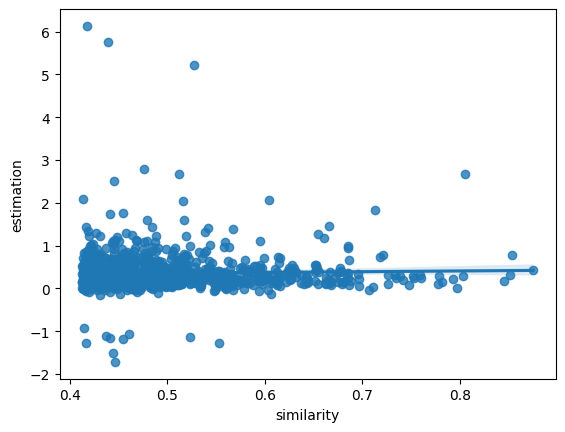

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9725
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.324
Time:                        13:23:00   Log-Likelihood:                 1056.0
No. Observations:                1000   AIC:                            -2108.
Df Residuals:                     998   BIC:                            -2098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5072      0.004    138.253      0.0

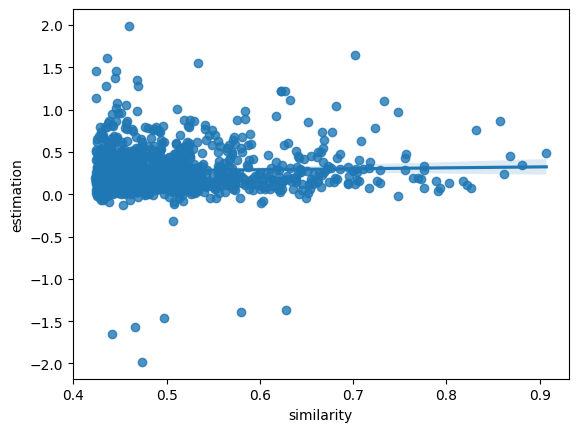

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5536
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.457
Time:                        13:23:01   Log-Likelihood:                 1057.3
No. Observations:                 995   AIC:                            -2111.
Df Residuals:                     993   BIC:                            -2101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5057      0.003    168.841      0.0

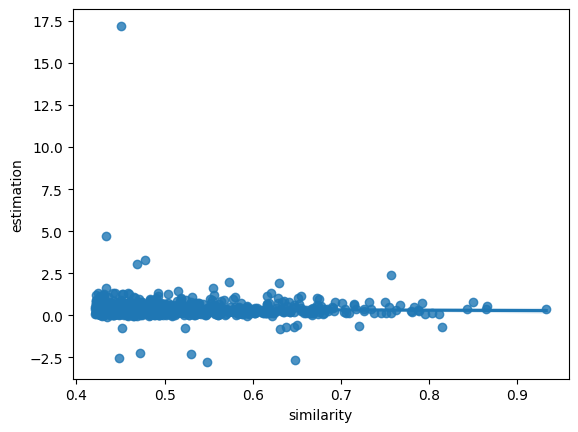

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.017
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.313
Time:                        13:23:01   Log-Likelihood:                 1136.8
No. Observations:                1000   AIC:                            -2270.
Df Residuals:                     998   BIC:                            -2260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5108      0.003    172.731      0.0

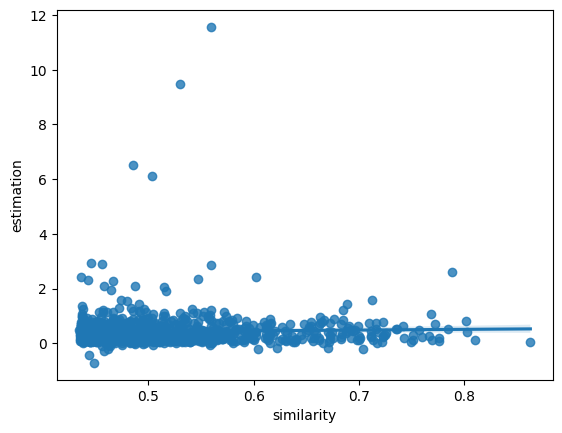

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.001199
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.972
Time:                        13:23:01   Log-Likelihood:                 1166.4
No. Observations:                1000   AIC:                            -2329.
Df Residuals:                     998   BIC:                            -2319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5200      0.003    150.949      0.0

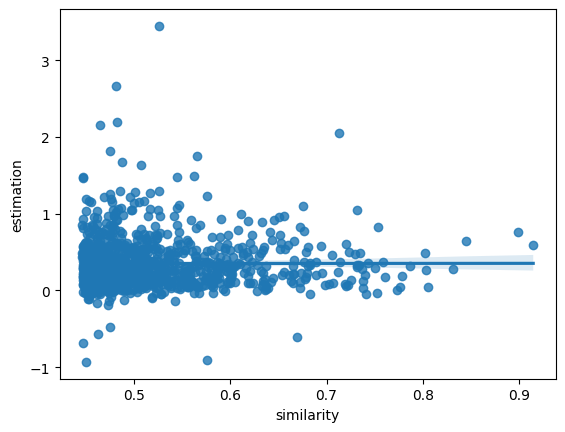

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9320
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.335
Time:                        13:23:01   Log-Likelihood:                 1178.9
No. Observations:                 997   AIC:                            -2354.
Df Residuals:                     995   BIC:                            -2344.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5416      0.003    174.761      0.0

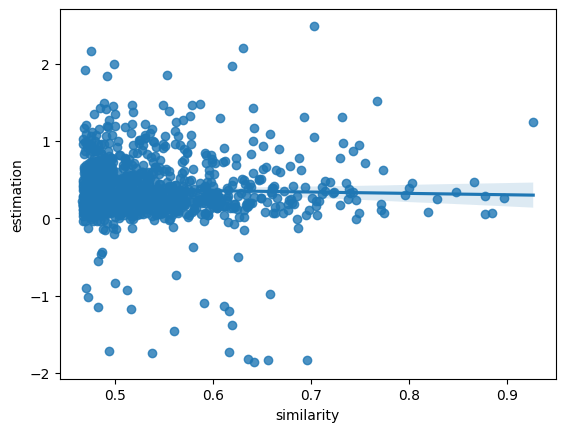

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.269
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.132
Time:                        13:23:02   Log-Likelihood:                 1126.3
No. Observations:                 999   AIC:                            -2249.
Df Residuals:                     997   BIC:                            -2239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5559      0.004    146.036      0.0

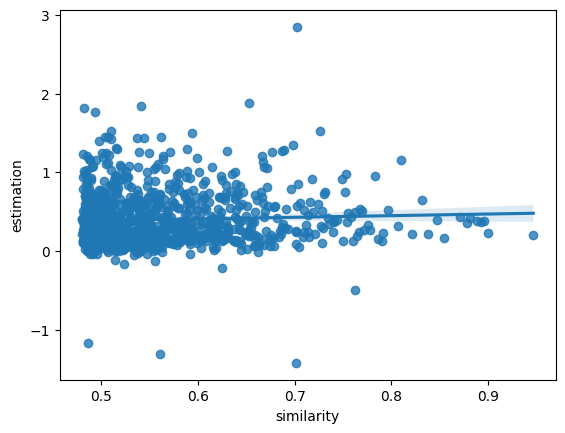

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.661
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.198
Time:                        13:23:02   Log-Likelihood:                 1143.5
No. Observations:                1000   AIC:                            -2283.
Df Residuals:                     998   BIC:                            -2273.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5680      0.004    162.221      0.0

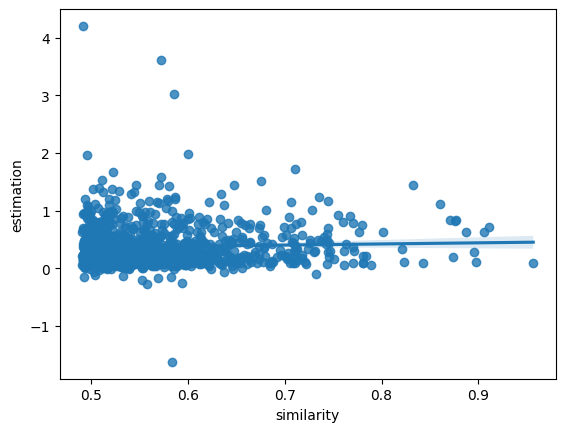

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4180
Date:                Sat, 19 Aug 2023   Prob (F-statistic):              0.518
Time:                        13:23:02   Log-Likelihood:                 1203.3
No. Observations:                 998   AIC:                            -2403.
Df Residuals:                     996   BIC:                            -2393.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5795      0.003    174.999      0.0

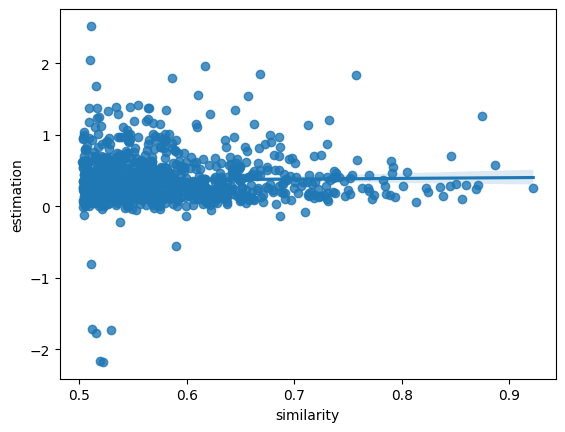

In [237]:
for year in range(2010, 2021):
    
    print(sm.OLS(result[result["year"] == year]["similarity"], sm.add_constant(result[result["year"] == year]["estimation"])).fit().summary())
    sns.regplot(data=result[result["year"] == year], x="similarity", y="estimation")
    plt.show()

## testing market neutral strategy profitability

12 year window of data is used for testing the model. t-11 to t-1 year is used for factor calculation, and the year t is used for testing the model. 

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

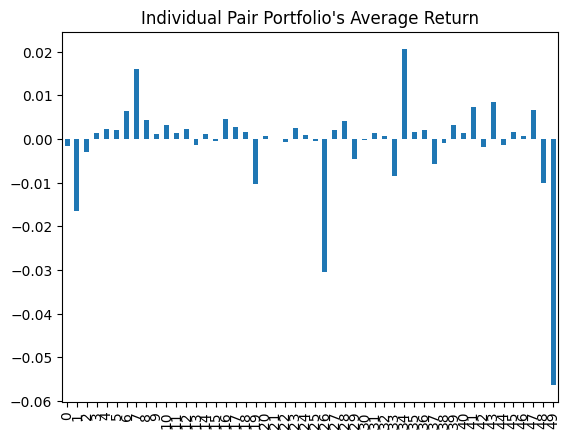

  8%|██████▍                                                                            | 1/13 [00:00<00:06,  1.87it/s]

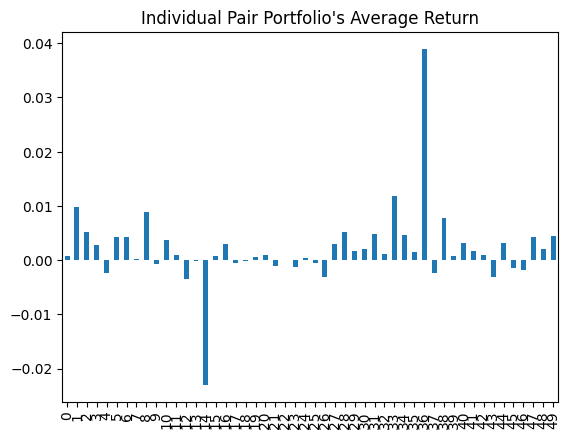

 15%|████████████▊                                                                      | 2/13 [00:00<00:05,  2.03it/s]

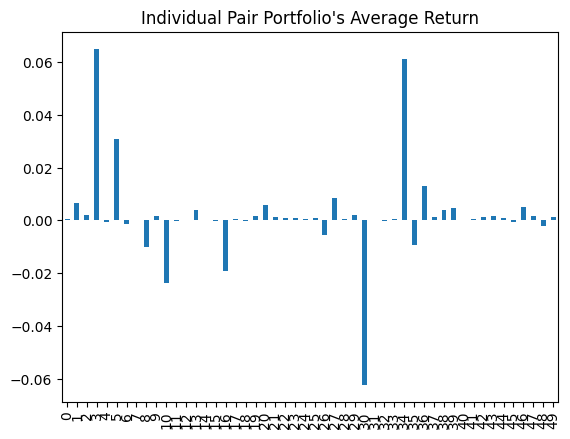

 23%|███████████████████▏                                                               | 3/13 [00:01<00:04,  2.06it/s]

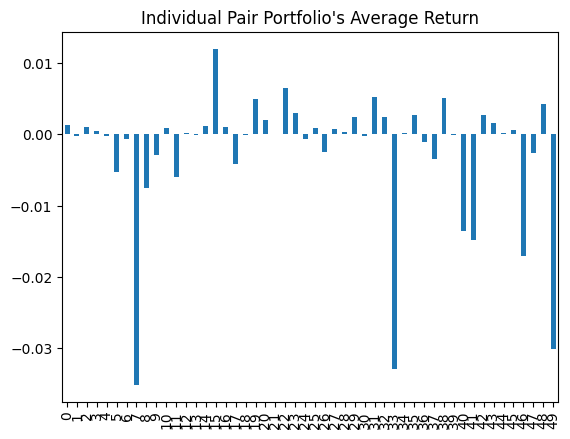

 31%|█████████████████████████▌                                                         | 4/13 [00:02<00:04,  1.99it/s]

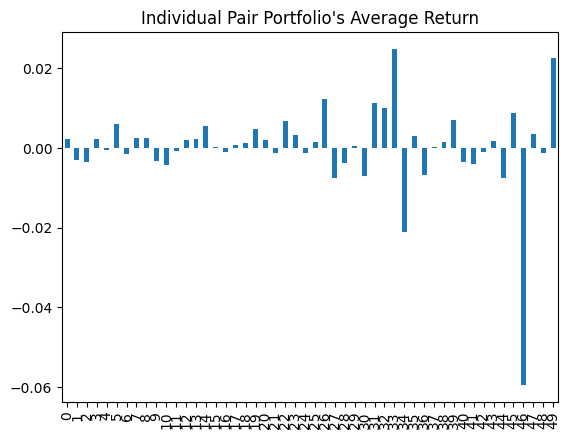

 38%|███████████████████████████████▉                                                   | 5/13 [00:02<00:04,  1.89it/s]

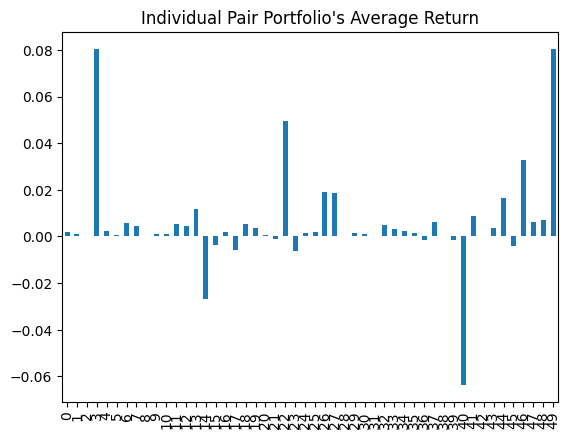

 46%|██████████████████████████████████████▎                                            | 6/13 [00:03<00:03,  1.78it/s]

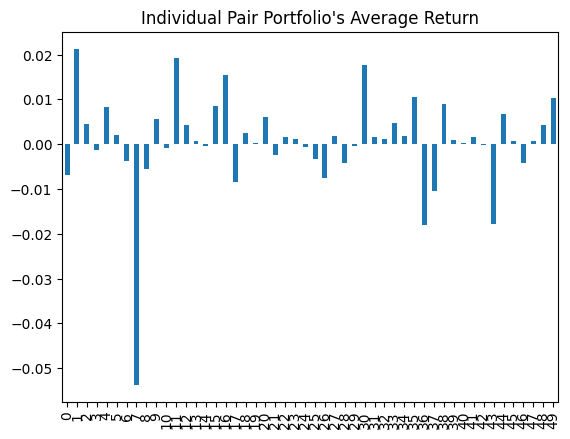

 54%|████████████████████████████████████████████▋                                      | 7/13 [00:03<00:03,  1.73it/s]

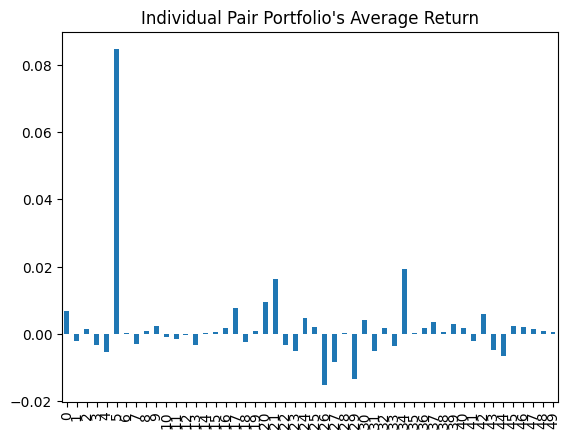

 62%|███████████████████████████████████████████████████                                | 8/13 [00:04<00:02,  1.69it/s]

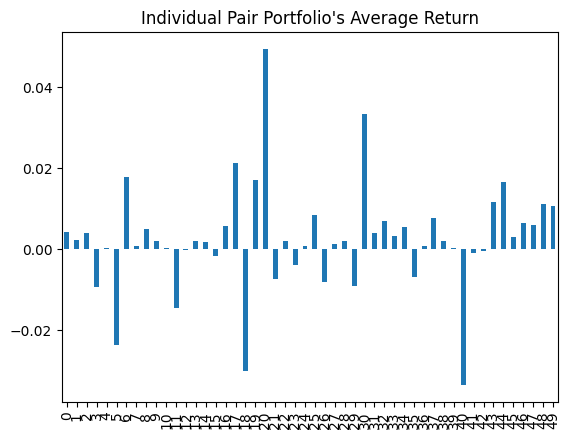

 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:05<00:02,  1.59it/s]

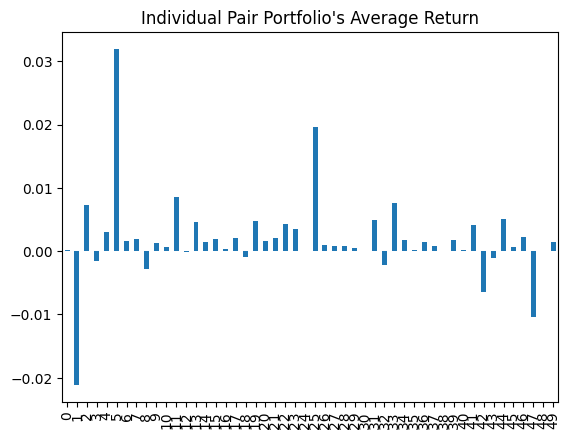

 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:05<00:02,  1.49it/s]

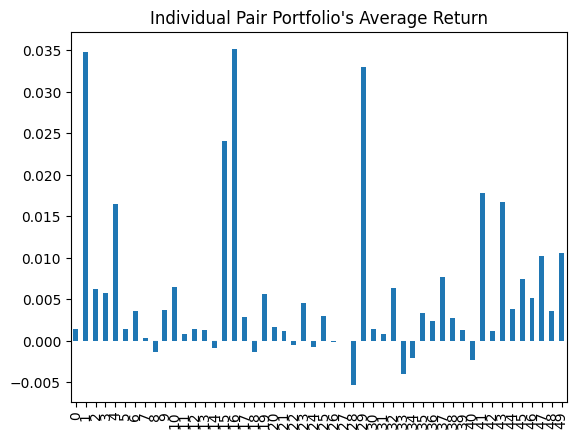

 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:06<00:01,  1.36it/s]

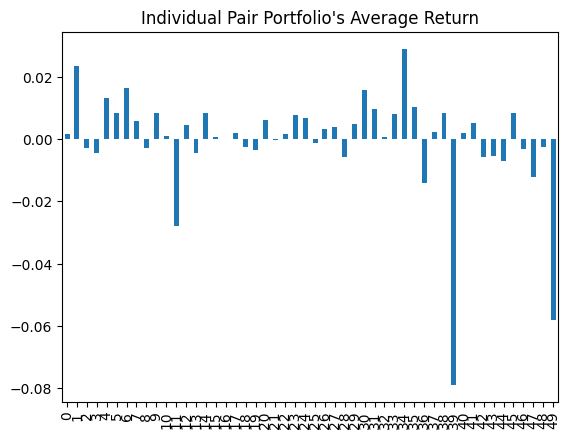

 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:07<00:00,  1.29it/s]

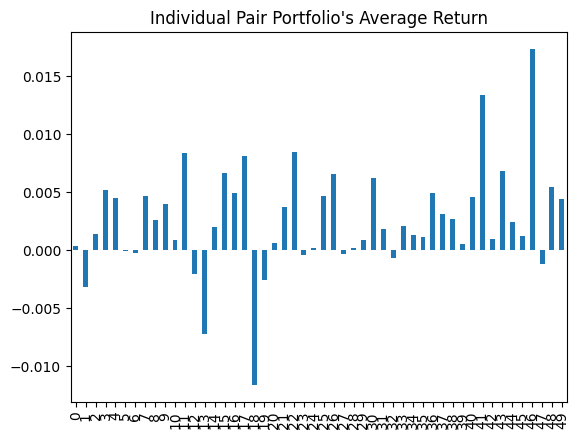

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.52it/s]


In [250]:
port = pd.Series(np.zeros((1)))

for year in tqdm(range(2009, 2022)):
    
    train = data[f"{year-15}":f"{year}"].dropna(axis=1)
    train0 = (train - train.shift(1).rolling(60).mean()) / train.shift(1).rolling(60).std()
    train0 = train0.dropna()
    dropCol = pd.Series(np.where((train0.abs() ==np.inf).any(axis=0).values, np.nan, train0.columns)).dropna().values
    train0 = train0[list(dropCol)]
    train= train[list(dropCol)]
    test = data[f"{year+1}-01":f"{year+1}-12"]
    #factor extraction
    model = PCA(n_components=50)
    model.fit(train0)
    factors = (train.loc[train.index, :] @ model.components_.T) / np.sum(model.components_, axis=1).reshape(1, -1)
    const = None

    riskLoading = pd.DataFrame(model.components_.T, index=train.columns)

    #calculating cosine similarity of factor loading
    #cosine similarity is free from leverage effect, as it consider less about the magnitude of the variables.
    cosi = pd.DataFrame(cosine_similarity(riskLoading), index=riskLoading.index, columns=riskLoading.index)
    
    for n in range(cosi.shape[0]):

        cosi.iloc[n ,n] = np.nan
    

    cosi = pd.DataFrame(np.tril(cosi, k=0), index=cosi.index, columns=cosi.index)
    #cosi = (cosi).abs()
    
    #find the most similar pair of stocks in risk chracteristics
    #the first 50 pairs are considered high biased sample and not considered for calculation.
    #Because of regression toward the mean, these 50 samples will not show good performance in out of sample.
    X = cosi.reset_index().melt(id_vars="index", value_vars=cosi.columns).sort_values(by="value").dropna().iloc[::-1, :]
    X = pd.DataFrame(X)
    x = list(X.iloc[50:100]["index"])
    y = list(X.iloc[50:100]["variable"])
    z = list(X.iloc[50:100]["value"])

    aList = []


    for n in range(len(x)):

        aList.append(testLongshort(x[n], y[n], const, train, test))

    pd.DataFrame(aList).T.mean().plot.bar(title="Individual Pair Portfolio's Average Return")
    plt.show()
    

    port = pd.concat([port, pd.DataFrame(aList).T.mean(axis=1)])


<Axes: >

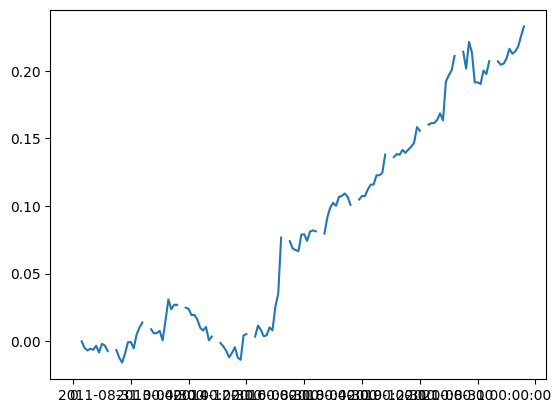

In [251]:
np.log1p(port).cumsum().plot.line()

In [252]:
np.expm1(np.log1p(port).dropna().rolling(12).sum().iloc[::12]).describe()

count    10.000000
mean      0.021420
std       0.033873
min      -0.023433
25%       0.004378
50%       0.017643
75%       0.027625
max       0.094639
dtype: float64

## Robustnesss Check

* Selected number of stocks
* model parameters(number of factor) change


In [176]:
from sklearn.linear_model import LinearRegression

In [177]:
data

,A005930,A373220,A207940,A000660,A051910,A006400,A005380,A035420,A000270,A068270,...,A900080,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950180
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.055332,NaN,NaN,NaN,NaN,-0.110822,-0.006668,NaN,-0.035038,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-28,0.016348,NaN,NaN,NaN,NaN,0.032702,-0.027421,NaN,0.012074,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-31,0.050416,NaN,NaN,NaN,NaN,0.066087,0.010833,NaN,-0.012069,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-30,-0.196790,NaN,NaN,NaN,NaN,-0.190057,-0.248944,NaN,-0.258106,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-31,0.111585,NaN,NaN,NaN,NaN,0.105436,0.144804,NaN,0.173746,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.027779,0.095937,-0.034858,-0.027508,0.048224,0.050958,-0.000130,-0.073442,-0.004958,-0.002713,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,-0.104433,-0.077776,-0.033652,-0.123955,-0.151795,-0.087040,-0.099499,-0.190099,-0.110166,-0.073853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,0.118415,0.238075,0.086801,-0.004769,0.167579,0.349853,-0.067942,-0.123992,-0.078007,0.094075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
len()

20

In [189]:
result = []

transact = 0.01


for stockNum in tqdm(range(75, 571, 25)):
    
    for factorNum in (range(10, 101, 5)):

        port = pd.Series([0])
        
        for year in (range(2009, 2022)):

            #train test split
            train = data[f"{year-15}":f"{year}"].dropna(axis=1)
            train0 = (train - train.shift(1).rolling(60).mean()) / train.shift(1).rolling(60).std()
            train0 = train0.dropna()
            dropCol = pd.Series(np.where((train0.abs() ==np.inf).any(axis=0).values, np.nan, train0.columns)).dropna().values
            train0 = train0[list(dropCol)]
            train= train[list(dropCol)]
            test = data[f"{year+1}-01":f"{year+1}-12"]
            #factor extraction
            model = PCA(n_components=factorNum)
            model.fit(train0)
            factors = (train.loc[train.index, :] @ model.components_.T) / np.sum(model.components_, axis=1).reshape(1, -1)
            const = None

            riskLoading = pd.DataFrame(model.components_.T, index=train.columns)

            cosi = pd.DataFrame(cosine_similarity(riskLoading), index=riskLoading.index, columns=riskLoading.index)

            for n in range(cosi.shape[0]):

                cosi.iloc[n ,n] = np.nan


            cosi = pd.DataFrame(np.tril(cosi, k=0), index=cosi.index, columns=cosi.index)

            #find the most similar pair of stocks in risk chracteristics
            X = cosi.reset_index().melt(id_vars="index", value_vars=cosi.columns).sort_values(by="value").dropna().iloc[::-1, :]
            X = pd.DataFrame(X)
            x = list(X.iloc[50:stockNum]["index"])
            y = list(X.iloc[50:stockNum]["variable"])
            z = list(X.iloc[50:stockNum]["value"])

            aList = []


            for n in range(len(x)):

                aList.append(testLongshort(x[n], y[n], const, train, test))

            port = pd.concat([port, pd.DataFrame(aList).T.mean(axis=1)])
        
        port = port.iloc[1:]
        
        tmp = {}
        tmp["stockNum"] = stockNum
        tmp["factorNum"] = factorNum
        tmp["avg"] = port.mean() * 12
        tmp["std"] = port.std() * np.sqrt(12)
        tmp["tval"] = port.mean() * np.sqrt(port.count()) / port.std()
        result.append(tmp)


 10%|████████▎                                                                          | 2/20 [03:18<29:56, 99.83s/it]C:\Users\inert\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 15%|████████████▎                                                                     | 3/20 [05:06<29:23, 103.73s/it]C:\Users\inert\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 20%|████████████████▍                                                                 | 4/20 [06:58<28:34, 107.19s/it]C:\Users\inert\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\inert\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getat

In [190]:
result= pd.DataFrame(result)
avg = result.drop(["std", "tval"], axis=1).pivot(columns="stockNum", index="factorNum")
tval = result.drop(["std", "avg"], axis=1).pivot(columns="stockNum", index="factorNum")

### Backtest Result

T-values and average returns.
Optimal factor number is 50, and stock number ranging 50-200.



#### Average

<Axes: xlabel='None-stockNum', ylabel='factorNum'>

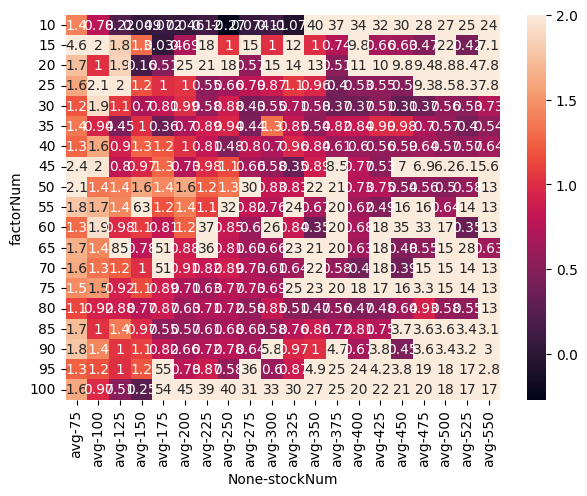

In [203]:
plt.figure(figsize=(7,5))
sns.heatmap(avg * 100, annot=True, vmax=2)

#### Tvalue

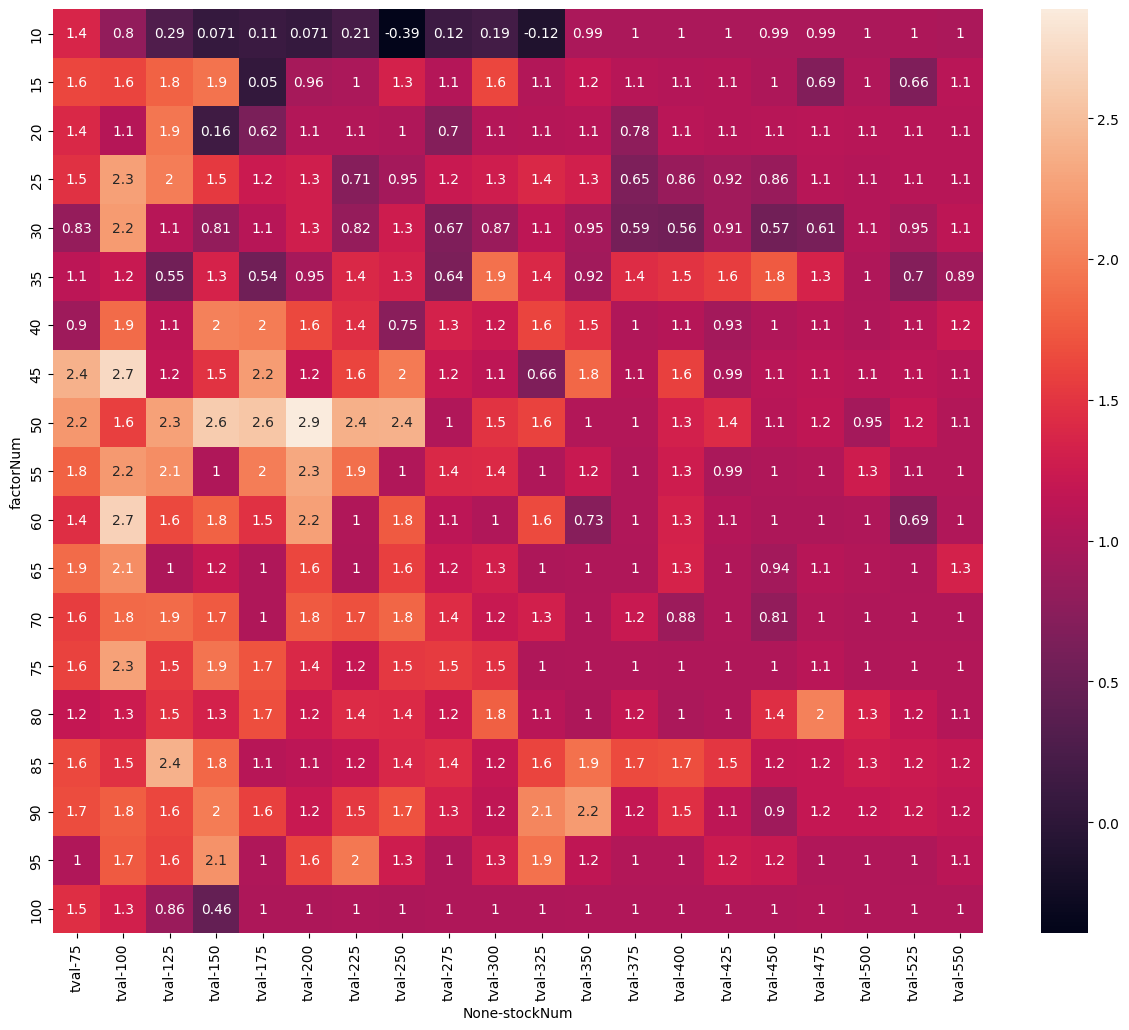

In [207]:
plt.figure(figsize=(15, 12))
sns.heatmap(tval, annot=True)
plt.savefig("tval.png")